## Figure 5

MOA predictions

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(patchwork))

source("viz_themes.R")
source("plotting_functions.R")
source("data_functions.R")

In [2]:
output_figure_base <- file.path("figures", "figure5")
extensions <- c(".png", ".pdf")

In [3]:
model_dir <- file.path("../2.MOA-prediction/L1000_CP_model_predictions/")
performance_dir <- file.path("../2.MOA-prediction/4.model_viz/performance_results")

In [6]:
# Load metrics results
metrics_file <- file.path(performance_dir, "all_performance_metrics.csv")

metrics_cols <- readr::cols(
    id_name = readr::col_character(),
    metrics = readr::col_character(),
    values = readr::col_double(),
    profile_tech = readr::col_character(),
    model = readr::col_character(),
    shuffle = readr::col_logical()
)

all_metrics_df <- readr::read_csv(metrics_file, col_types = metrics_cols)

# Process data
all_metrics_df$profile_tech <- dplyr::recode(
    all_metrics_df$profile_tech,
    `Cell painting` = "Cell Painting",
    `Cell painting subsample` = "Cell Painting (subsample)"
)
all_metrics_df$metrics <- dplyr::recode(
    all_metrics_df$metrics, `Precision-Recall_AUC` = "Precision-recall", `ROC_AUC` = "ROC"
)
all_metrics_df$metrics <- factor(all_metrics_df$metrics, levels = c("ROC", "Precision-recall"))
all_metrics_df$model <- factor(
    all_metrics_df$model,
    levels = c("Ml-KNN", "Simple NN", "1D-CNN", "ResNet", "TabNet", "Models Ensemble")
)
all_metrics_df$model <- dplyr::recode(
    all_metrics_df$model, `Models Ensemble` = "Ensemble"
)

## Panel A

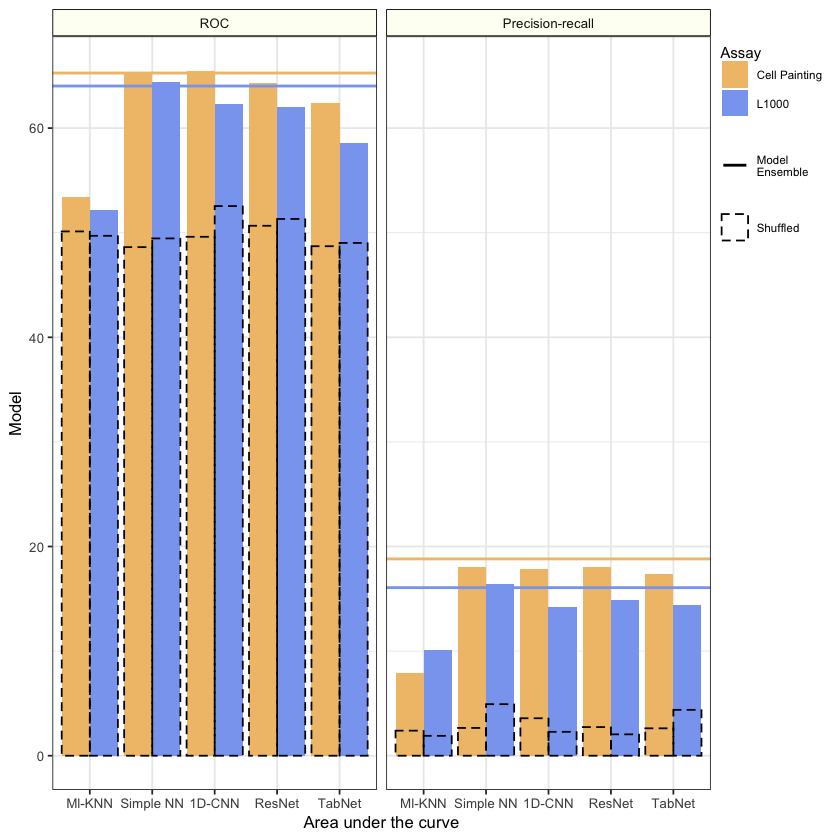

In [9]:
# Panel A
panel_a_df <- all_metrics_df %>%
    dplyr::filter(profile_tech %in% c("Cell Painting", "L1000"))

ensemble_df <- panel_a_df %>%
    dplyr::filter(model == "Ensemble")

panel_a_df <- panel_a_df %>%
    dplyr::filter(model != "Ensemble")

panel_a_gg <- (
    ggplot(data = NULL, aes(x = model, y = values))
    + geom_bar(
        data = panel_a_df %>% dplyr::filter(!shuffle),
        stat = "identity",
        aes(fill = profile_tech),
        position = "dodge"
    )
    + geom_bar(
        data = panel_a_df %>% dplyr::filter(shuffle),
        stat = "identity",
        aes(color = profile_tech),
        alpha = 0,
        position = "dodge",
        linetype = "dashed"
    )
    + figure_theme
    + theme(
        legend.spacing.y = unit(0.01, "cm"),
        legend.box.spacing = unit(0.01, "cm"),
        legend.justification = "top"
    )
    + scale_fill_manual("Assay", values = assay_colors)
    + scale_color_manual(breaks = "Cell Painting", name = "", values = c("black", "black"), labels = c("Shuffled"))
    + scale_linetype_manual(name = "", values = "solid", labels = "Model\nEnsemble")
    + geom_hline(data = ensemble_df, aes(yintercept = values, linetype = "Ensemble"), color = rep(paste(assay_colors), 2), lwd = 0.8)    
    + facet_wrap("~metrics")
    + xlab("Area under the curve")
    + ylab("Model")
    + guides(
        fill = guide_legend(order = 1),
        color = guide_legend(order = 3),
        linetype = guide_legend(order = 2)
    )
)

panel_a_gg

## Supplementary Fig

In [17]:
# Load and process dose results
metrics_dose_file <- file.path(performance_dir, "all_performance_metrics_by_dose.csv")

metrics_dose_cols <- readr::cols(
    id_name = readr::col_character(),
    metrics = readr::col_character(),
    values = readr::col_double(),
    class = readr::col_character(),
    model = readr::col_character(),
    profile_tech = readr::col_character()
)

all_dose_metrics_df <- readr::read_csv(metrics_dose_file, col_types = metrics_dose_cols) %>%
    dplyr::filter(profile_tech != "CP_L1000") %>%
    dplyr::mutate(performance = values * 100)

# Process data
all_dose_metrics_df$profile_tech <- dplyr::recode(
    all_dose_metrics_df$profile_tech,
    cp = "Cell Painting",
    cpsubsample = "Cell Painting (subsample)"
)

all_dose_metrics_df$metrics <- dplyr::recode(all_dose_metrics_df$metrics, pr_auc_score = "Precision-recall")
all_dose_metrics_df$model <- dplyr::recode(
    all_dose_metrics_df$model,
    mlknn = "Ml-KNN", simplenn = "Simple NN", cnn = "1D-CNN", resnet = "ResNet", tabnet = "TabNet"
)

all_dose_metrics_df$model <- factor(
    all_dose_metrics_df$model,
    levels = c("Ml-KNN", "Simple NN", "1D-CNN", "ResNet", "TabNet", "Models Ensemble")
)

all_dose_metrics_df$class <- dplyr::recode(
    all_dose_metrics_df$class,
    dose_1 = dose_order[1], dose_2 = dose_order[2], dose_3 = dose_order[3], dose_4 = dose_order[4], dose_5 = dose_order[5], dose_6 = dose_order[6]
)
all_dose_metrics_df$class <- factor(all_dose_metrics_df$class, levels = dose_order)

head(all_dose_metrics_df)

id_name,metrics,values,class,model,profile_tech,performance
<chr>,<chr>,<dbl>,<fct>,<fct>,<chr>,<dbl>
moa_dose_cp_mlknn_1,Precision-recall,0.009407825,0.04 uM,Ml-KNN,Cell Painting,0.9407825
moa_dose_cp_resnet_1,Precision-recall,0.045829176,0.04 uM,ResNet,Cell Painting,4.5829176
moa_dose_cp_cnn_1,Precision-recall,0.051099634,0.04 uM,1D-CNN,Cell Painting,5.1099634
moa_dose_cp_tabnet_1,Precision-recall,0.047987247,0.04 uM,TabNet,Cell Painting,4.7987247
moa_dose_cp_simplenn_1,Precision-recall,0.045708278,0.04 uM,Simple NN,Cell Painting,4.5708278
moa_dose_cp_mlknn_2,Precision-recall,0.009730027,0.12 uM,Ml-KNN,Cell Painting,0.9730027


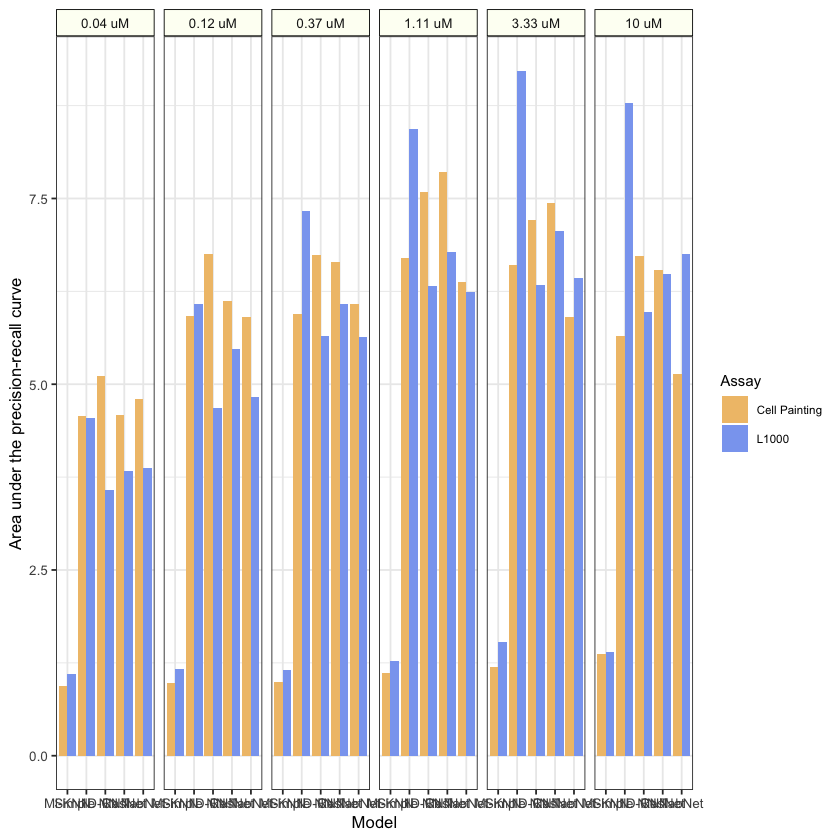

In [18]:
sup_fig_gg <- (
    ggplot(
        all_dose_metrics_df %>% dplyr::filter(profile_tech != "Cell Painting (subsample)"),
        aes(x = model, y = performance))
    + geom_bar(aes(fill = profile_tech), position = "dodge", stat = "identity")
    + facet_grid("~class")
    + figure_theme
    + scale_fill_manual("Assay", values = assay_colors)
    + xlab("Model")
    + ylab("Area under the precision-recall curve")
)

sup_fig_gg

## Panel B

In [19]:
metrics_moa_file <- file.path(performance_dir, "moa_precision_recall.csv")

metrics_dose_cols <- readr::cols(
    moa = readr::col_character(),
    cp_values = readr::col_double(),
    L1_values = readr::col_double(),
    cp_L1_values = readr::col_double()
)

moa_metrics_df <- readr::read_csv(metrics_moa_file, col_types = metrics_dose_cols)
head(moa_metrics_df)

moa,cp_values,L1_values,cp_values_subsample,cp_L1_values
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
proteasome inhibitor,0.9974452,0.9958028,0.9980918,0.9981941
pkc activator,0.9877850,1.0000000,0.5830423,1.0000000
plk inhibitor,0.9765958,0.6106595,0.9741843,0.9103340
mek inhibitor,0.9707568,0.8592149,0.8793493,0.9163852
glucocorticoid receptor agonist,0.9411635,0.8673451,0.9534387,0.9687252
hdac inhibitor,0.8063970,0.9632244,0.8127948,0.9642520


In [20]:
color_logic <- moa_metrics_df$cp_values > 0.2 | moa_metrics_df$L1_values > 0.3

# Baselines derived from 1.moa_predictions_visualization.ipynb
cp_baseline <- 0.01187097486689307
l1000_baseline <- 0.010994768416209987

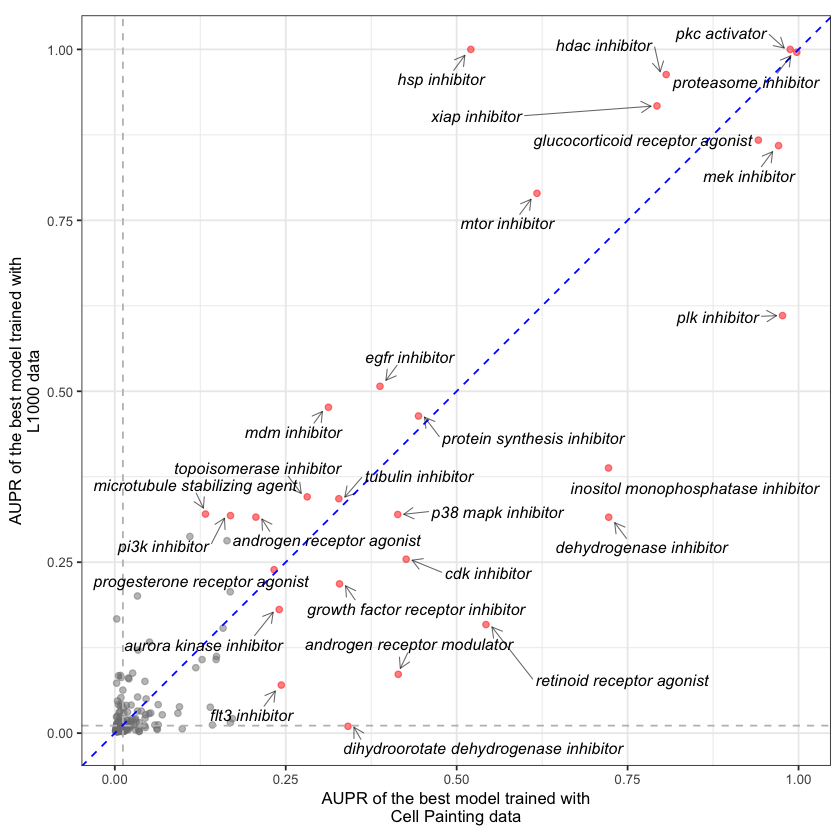

In [21]:
panel_b_gg <- (
    ggplot(moa_metrics_df, aes(x = cp_values, y = L1_values))
    + geom_point(color = ifelse(color_logic, "red", "grey50"), alpha = 0.5)
    + figure_theme
    + geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "blue")
    + xlab("AUPR of the best model trained with\nCell Painting data")
    + ylab("AUPR of the best model trained with\nL1000 data")
    + coord_fixed()
    + geom_hline(yintercept = l1000_baseline, linetype = "dashed", color = "grey")
    + geom_vline(xintercept = cp_baseline, linetype = "dashed", color = "grey")
    + geom_text_repel(
        data = subset(moa_metrics_df, color_logic),
        arrow = arrow(length = unit(0.015, "npc")),
        segment.size = 0.3,
        segment.alpha = 0.6,
        size = 3.4,
        fontface = "italic",
        box.padding = 0.5,
        point.padding = 0.5,
        aes(
            x = cp_values,
            y = L1_values,
            label = moa,
        )
    )
)

panel_b_gg

## Combine plots

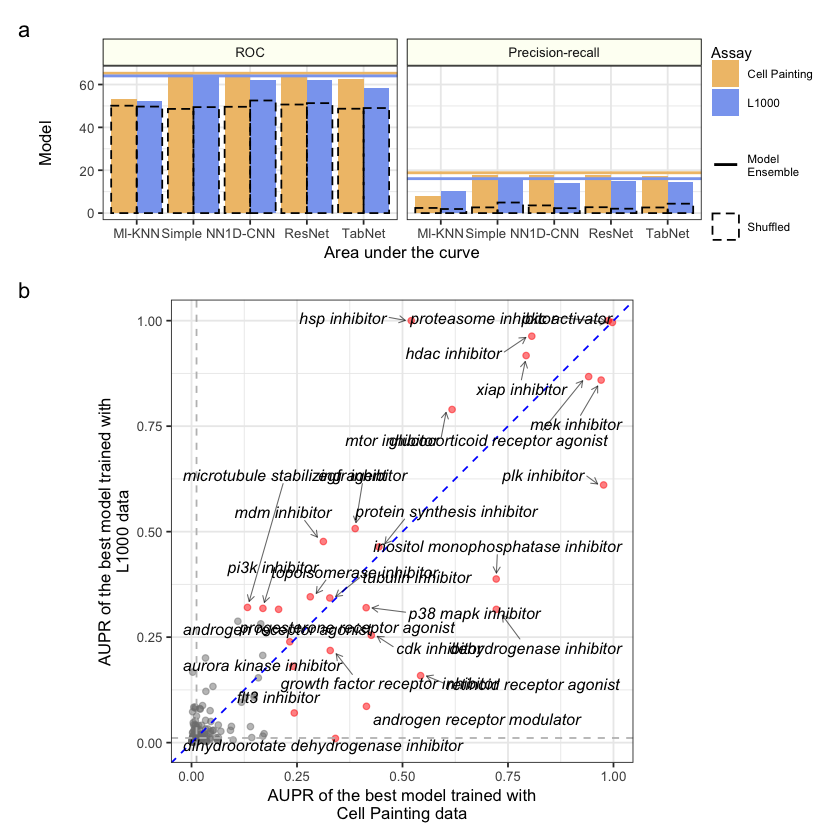

In [22]:
figure5_gg <- (
    panel_a_gg
    / panel_b_gg
    + plot_layout(
        ncol = 1,
        heights = c(1, 3),
        widths = NA
    )
    + plot_annotation(
        tag_levels = "a"
    )
)
figure5_gg

In [12]:
for (extension in extensions) {
    output_file <- paste0(output_figure_base, extension)
    cowplot::save_plot(output_file, figure5_gg, base_width = 8, base_height = 11, dpi = 500)
}

## Compare compound median scores to MOA predictions

In [40]:
# Load median scores
results_dir <- file.path("../1.Data-exploration/Profiles_level4/results")
cell_painting_comp_df <- load_median_correlation_scores(assay = "cellpainting", results_dir = results_dir)
l1000_comp_df <- load_median_correlation_scores(assay = "l1000", results_dir = results_dir)

comp_df <- dplyr::bind_rows(cell_painting_comp_df, l1000_comp_df)
comp_df$dose <- factor(comp_df$dose, levels = dose_order)

# Load MOA info
file <- file.path("..", "2.MOA-prediction", "1.compound_split_train_test", "data", "split_moas_cpds.csv")

align_cols <- readr::cols(
    pert_iname = readr::col_character(),
    moa = readr::col_character(),
    train = readr::col_logical(),
    test = readr::col_logical(),
    marked = readr::col_logical()
)

align_df <- readr::read_csv(file, col_types = align_cols)

moa_metrics_melt_df <- moa_metrics_df %>%
    reshape2::melt(
        id.vars = "moa",
        value.vars = c("cp_values", "L1_values", "cp_L1_values"),
        variable.name = "assay",
        value.name = "aupr"
    )

moa_metrics_melt_df$assay <- dplyr::recode(
    moa_metrics_melt_df$assay,
    cp_values = "Cell Painting", L1_values = "L1000", cp_L1_values = "both"
)

prediction_by_replicate_score_df <- moa_metrics_melt_df %>%
    dplyr::left_join(align_df, by = c("moa" = "moa")) %>%
    dplyr::left_join(comp_df, by = c("pert_iname" = "compound", "assay" = "assay")) %>%
    tidyr::drop_na()

head(prediction_by_replicate_score_df, 3)

Warning message:
“Column `assay` joining factor and character vector, coercing into character vector”


,moa,assay,aupr,pert_iname,train,test,marked,no_of_replicates,dose,median_replicate_score
,<chr>,<chr>,<dbl>,<chr>,<lgl>,<lgl>,<lgl>,<dbl>,<fct>,<dbl>
1,proteasome inhibitor,Cell Painting,0.9974452,bortezomib,FALSE,TRUE,TRUE,5,0.04 uM,0.5417199
2,proteasome inhibitor,Cell Painting,0.9974452,bortezomib,FALSE,TRUE,TRUE,5,0.12 uM,0.5500991
3,proteasome inhibitor,Cell Painting,0.9974452,bortezomib,FALSE,TRUE,TRUE,5,0.37 uM,0.5910415


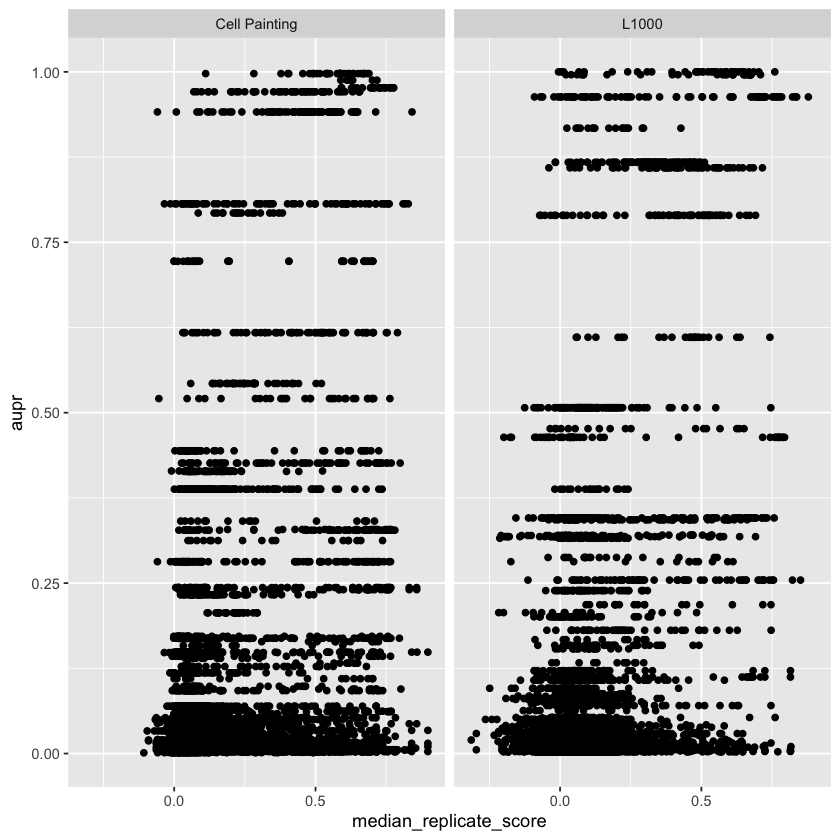

In [41]:
(
    ggplot(prediction_by_replicate_score_df, aes(x = median_replicate_score, y = aupr))
    + geom_point()
    + facet_wrap("~assay")
)